In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import seaborn as sns
import pickle

## Create the Data

In [2]:
# Read Dataset
FILE = "Ten-Year-Demand.csv"
allData = pd.read_csv(FILE, names=['Year', 'Count', 'Demand'], skiprows=1)

# Fill NaN with previous year 
allData = allData.fillna(method='ffill')

# Years to int and months from 1 to 12
allData.Year = allData.Year.astype(np.int)
allData['Month'] = allData.Count.apply(lambda x: x % 12 if x % 12 != 0 else 12)
allData["Year-Month"] = allData["Year"].map(str) + allData['Month'].map(str)
allData.head(24)

,Year,Count,Demand,Month,Year-Month
0,1996,1,79.35,1,19961
1,1996,2,75.78,2,19962
2,1996,3,86.32,3,19963
3,1996,4,72.60,4,19964
4,1996,5,74.86,5,19965
5,1996,6,83.81,6,19966
6,1996,7,79.80,7,19967
7,1996,8,62.41,8,19968
8,1996,9,85.41,9,19969
9,1996,10,83.11,10,199610


In [3]:
def predictingOneAheadFourMethods(realSeriesVal, frequency =12, startPos = 60, numToUse = 60):
    ## In order we try ('add' = additive, 'mul' = multiplicative)
    # 1) HolterWinter trend/seasonal = add/add all Data
    # 2) HolterWinter trend/seasonal = add/add using only the last 60 points each time (last 5 years)
    # 3) HolterWinter trend/seasonal = add/mul all Data
    # 4) HolterWinter trend/seasonal = add/mul using only the last 60 points each time (last 5 years)
    totVal = len(realSeriesVal)
    toRet = np.zeros((totVal-startPos, 5))
    for i in range(startPos, totVal):
        fit1 = ExponentialSmoothing(realSeriesVal[0:i], seasonal_periods=frequency, trend='add', seasonal='add').fit(use_boxcox=True)
        fit2 = ExponentialSmoothing(realSeriesVal[(i-numToUse):i], seasonal_periods=frequency, trend='add', seasonal='add').fit(use_boxcox=True)
        fit3 = ExponentialSmoothing(realSeriesVal[0:i], seasonal_periods=frequency, trend='add', seasonal='mul').fit(use_boxcox=True)
        fit4 = ExponentialSmoothing(realSeriesVal[(i-numToUse):i], seasonal_periods=frequency, trend='add', seasonal='mul').fit(use_boxcox=True)
        toRet[i-startPos,:] = [fit1.forecast(1)[0], fit2.forecast(1)[0], fit3.forecast(1)[0], fit4.forecast(1)[0], realSeriesVal[i]]
    return toRet


In [4]:
print('We are going to start at period 60 and go up to the last period')
print('in the data predicting always the next period')

valForecasted = predictingOneAheadFourMethods(allData.Demand.values, \
                            frequency =12, startPos = 60, numToUse = 60)

We are going to start at period 60 and go up to the last period
in the data predicting always the next period


In [5]:
months = [i % 12 for i in range(len(allData.Demand.values))]

In [6]:
print(str(60 + len(valForecasted[:,0])))
print(len(allData.Demand.values))

120
120


## The Methods are In the Same Order as in predictingOneAheadFourMethods

In [7]:
pred = np.zeros((len(valForecasted[:,4]), 4))
for i in range(4):
    pred[:, i] = valForecasted[:,4]

In [8]:
## l2 error
print('l2 Average Error')
np.average((valForecasted[:,:4] - pred) *(valForecasted[:,:4] - pred), axis = 0)

l2 Average Error


array([10.71124363, 12.97878938, 10.08126238, 13.52272541])

In [9]:
## l2 error, last 36
print('l2 Average Error')
np.average((valForecasted[:,:4][-36:] - pred[-36:]) *(valForecasted[:,:4][-36:] - pred[-36:]), axis = 0)

l2 Average Error


array([5.04621143, 8.74583935, 4.89019292, 8.83561207])

In [10]:
## l1 error
print('l1 Average Error')
np.average(np.abs(valForecasted[:,:4] - pred) , axis = 0)

l1 Average Error


array([2.35461018, 2.69651313, 2.24845048, 2.86820581])

In [11]:
## As percentage of error
print('As percentage of error')
np.average(np.abs((valForecasted[:,:4] - pred)/ valForecasted[:,:4]), axis =0) *100


As percentage of error


array([2.40043268, 2.7784206 , 2.29346203, 2.94928438])

In [12]:
## As percentage of error.. Last 36 Predictions
print('As percentage of error')
np.average(np.abs((valForecasted[:,:4][-36:] - pred[-36:])/valForecasted[:,:4][-36:]), axis =0) *100

As percentage of error


array([1.76302469, 2.38975247, 1.73767019, 2.54398847])

In [13]:
## As Loss Function
print('As Loss Function')
np.average(np.maximum((valForecasted[:,:4] - pred),0) *1 + np.maximum((pred- valForecasted[:,:4]),0) *3, axis =0)

As Loss Function


array([4.21720453, 5.46163646, 3.95357677, 5.72480729])

## Plots

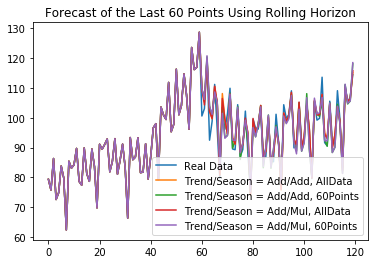

In [14]:
totPoints = len(allData.Demand.values)
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(0,totPoints)
plt.plot(x, allData.Demand.values[:], label='Real Data')
plt.plot(x, np.append(allData.Demand.values[0:60], valForecasted[:,0]), label='Trend/Season = Add/Add, AllData')
plt.plot(x, np.append(allData.Demand.values[0:60], valForecasted[:,1]), label='Trend/Season = Add/Add, 60Points')
plt.plot(x, np.append(allData.Demand.values[0:60], valForecasted[:,2]), label='Trend/Season = Add/Mul, AllData')
plt.plot(x, np.append(allData.Demand.values[0:60], valForecasted[:,3]), label='Trend/Season = Add/Mul, 60Points')
plt.title('Forecast of the Last '+str(len(valForecasted[:,0]))+' Points Using Rolling Horizon')
plt.rcParams['figure.figsize'] = [20, 10]
plt.legend()
plt.show()


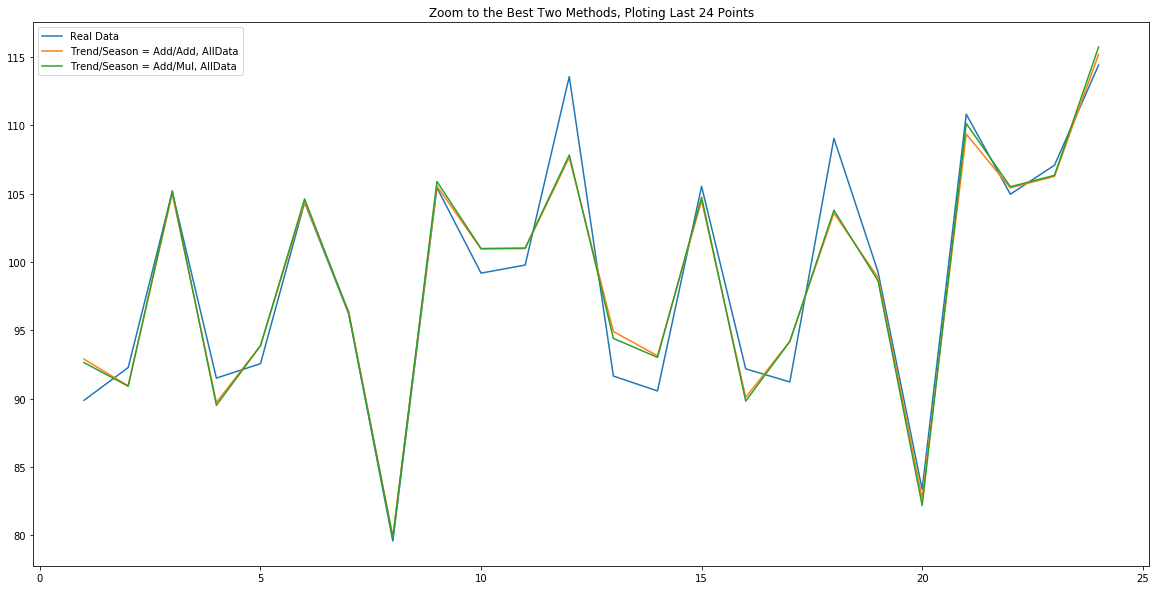

In [15]:
import matplotlib.pyplot as plt
import numpy as np
pointsToUse = 24
x = np.arange(1,pointsToUse+1)
plt.plot(x, allData.Demand.values[-pointsToUse:], label='Real Data')
plt.plot(x, valForecasted[:,0][-pointsToUse:], label='Trend/Season = Add/Add, AllData')
#     plt.plot(x, valForecasted[:,1][-pointsToUse:], label='Trend/Season = Add/Add, 60Points')
plt.plot(x, valForecasted[:,2][-pointsToUse:], label='Trend/Season = Add/Mul, AllData')
#     plt.plot(x, valForecasted[:,3][-pointsToUse:], label='Trend/Season = Add/Mul, 60Points')
plt.title('Zoom to the Best Two Methods, Ploting Last '+str(pointsToUse)+' Points')
plt.rcParams['figure.figsize'] = [20, 10]
plt.legend()
plt.show()

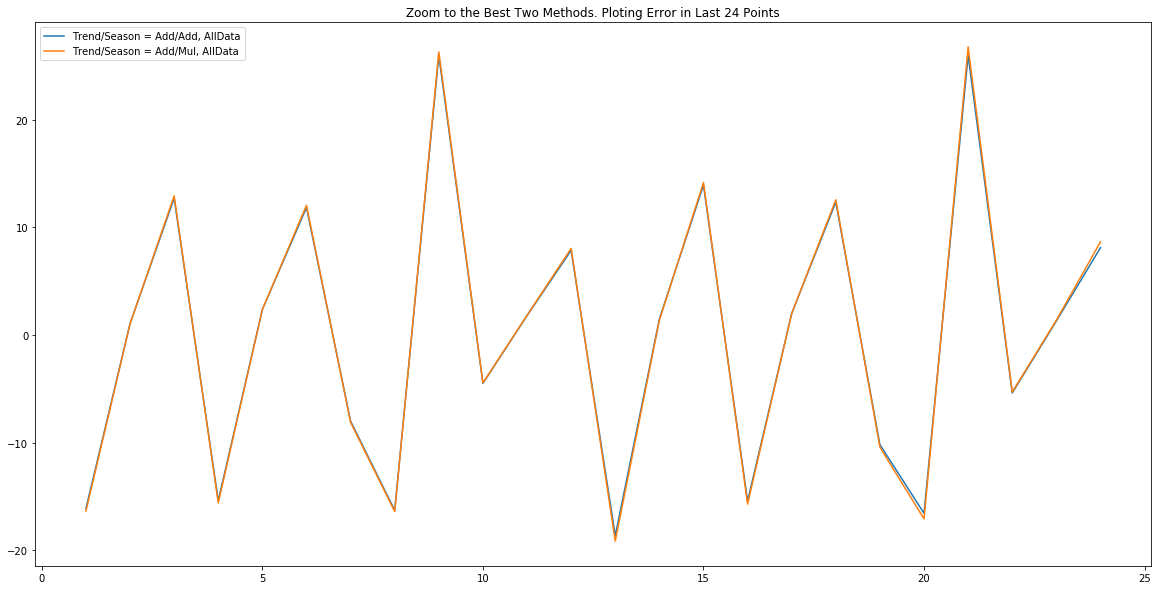

In [16]:
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(1,pointsToUse+1)
plt.plot(x, valForecasted[:,0][-pointsToUse:] -allData.Demand.values[-pointsToUse-1:-1], label='Trend/Season = Add/Add, AllData')
#     plt.plot(x, valForecasted[:,1][-pointsToUse:], label='Trend/Season = Add/Add, 60Points')
plt.plot(x, valForecasted[:,2][-pointsToUse:] -allData.Demand.values[-pointsToUse-1:-1], label='Trend/Season = Add/Mul, AllData')
#     plt.plot(x, valForecasted[:,3][-pointsToUse:], label='Trend/Season = Add/Mul, 60Points')
plt.title('Zoom to the Best Two Methods. Ploting Error in Last '+str(pointsToUse)+' Points')
plt.rcParams['figure.figsize'] = [20, 10]
plt.legend()
plt.show()

In [17]:
def avgL1ErrorPerMonth(errorMat, freq = 12):
    rows, mets = np.shape(errorMat)
    counts = np.zeros(freq)
    errors = np.zeros((freq, mets))
    for i in range(rows):
        errors[i % freq, : ] +=  errorMat[i,:]
        counts[i % freq] += 1
    return errors, counts

pointsToUse = 60

error36, count36 = avgL1ErrorPerMonth(np.abs(valForecasted[-pointsToUse:,:4] - pred[-pointsToUse:]))

print('L1 Error Average Per Month')
print('          , Method-1,  Method-2,  Method-3,  Method-4')
for i in range(np.shape(error36)[0]):
    print('Month '+str(months[-pointsToUse+i])+': '+str(error36[i]/count36[i]))


L1 Error Average Per Month
          , Method-1,  Method-2,  Method-3,  Method-4
Month 0: [4.4158427  3.65322054 4.22001141 4.05147984]
Month 1: [1.97163107 2.57479383 1.76302156 3.05916667]
Month 2: [0.88916466 0.92777992 0.85415566 1.45026409]
Month 3: [3.27938746 4.30283278 3.2658355  4.23451111]
Month 4: [1.94641293 2.04892029 2.06188691 2.13070765]
Month 5: [2.94347122 3.59968702 2.73330964 3.46165048]
Month 6: [3.38696339 4.18875709 3.24108162 4.76499245]
Month 7: [1.01017775 1.66062011 0.94777897 1.4696906 ]
Month 8: [2.29803979 1.64748596 1.70398291 1.73151296]
Month 9: [1.53856498 1.89085844 1.58668042 1.95928315]
Month 10: [2.09166167 2.40290798 2.07747024 2.71418067]
Month 11: [2.48400457 3.46029364 2.52619092 3.39103   ]


## NewsVendor Part 

As HW I only used the one with best performance found above. Sometimes I call the prediction from

In [18]:
## Adding the epsilon to bias the series

## This is the method shown in the report
def BiasedSeriesNormal(hwSeries, realData, startPred = 60, startNewSeries = 84, frequency = 12):
    def AvgError(currentPoint, startPred,  hwSeries, realData, frequency):
        seaInd = (currentPoint - startPred) % frequency
        errors = []
        for i in range(startPred, currentPoint):
            if (i - startPred) % frequency == seaInd:
                errors.append(hwSeries[i] - realData[i])
        return np.std(np.array(errors))
    newSeries = np.zeros(len(hwSeries))
    newSeries[:startNewSeries] = hwSeries[:startNewSeries]
    for i in range(startNewSeries, len(hwSeries)):
        error = AvgError(i, startPred, hwSeries, realData, frequency)
        newSeries[i] = hwSeries[i] + (2.0/3)*error
    return newSeries
        
## Other way of obtaining a bias term
def BiasedSeriesUniform(hwSeries, realData, startPred = 60, startNewSeries = 84, frequency = 12):
    def AvgError(currentPoint, startPred,  hwSeries, realData, frequency):
        seaInd = (currentPoint - startPred) % frequency
        absError = 0.001
        absErrors = []
        errors = []
        for i in range(startPred, currentPoint):
            if (i - startPred) % frequency == seaInd:
                absError +=  np.abs(hwSeries[i] - realData[i])
                absErrors.append(absError)
        return absError/len(absErrors) + 2 * np.std(np.array(absErrors))
    newSeries = np.zeros(len(hwSeries))
    newSeries[:startNewSeries] = hwSeries[:startNewSeries]
    for i in range(startNewSeries, len(hwSeries)):
        error = AvgError(i, startPred, hwSeries, realData, frequency)
        newSeries[i] = hwSeries[i] + (1.0/4.0)*error
    return newSeries
        
    

In [19]:
hwToUse = valForecasted[:,0]

biasSeriesNormal = BiasedSeriesNormal(np.append(allData.Demand.values[0:60], hwToUse),\
            np.append(allData.Demand.values[0:60], valForecasted[:,4]), startNewSeries = 84)
biasSeriesUnif = BiasedSeriesUniform(np.append(allData.Demand.values[0:60], hwToUse),\
            np.append(allData.Demand.values[0:60], valForecasted[:,4]), startNewSeries = 84)

In [20]:
## As Loss Function For Biased Last 20
lossBiasedNormal = \
    np.average(np.maximum(biasSeriesNormal[-36:] - valForecasted[:,4][-36:],0)) *1 \
        + np.average(np.maximum(valForecasted[:,4][-36:] - biasSeriesNormal[-36:],0)) *3
lossBiasedUnif = \
    np.average(np.maximum(biasSeriesUnif[-36:] - valForecasted[:,4][-36:],0)) *1 \
        + np.average(np.maximum(valForecasted[:,4][-36:] - biasSeriesUnif[-36:],0)) *3
        
lossBestHW = \
    np.average(np.maximum(hwToUse[-36:] - valForecasted[:,4][-36:],0)) *1 \
        + np.average(np.maximum(valForecasted[:,4][-36:] - hwToUse[-36:],0)) *3

print('Let us print the average lost for the last 36 points using newsvendor, the uniform, and the original HW')
    
    
print('lossBiasedNormal: '+str(lossBiasedNormal))
print('lossBiasedUnif: '+str(lossBiasedUnif))
print('lossBestHW: '+str(lossBestHW))

Let us print the average lost for the last 36 points using newsvendor, the uniform, and the original HW
lossBiasedNormal: 3.054192815780511
lossBiasedUnif: 2.8722937159925666
lossBestHW: 3.758399811296422


In [21]:
## Comparing MAPE, MSE of Biased vs HW alone

mseBiased = np.average((biasSeriesNormal[-36:] - valForecasted[:,4][-36:])*\
                       (biasSeriesNormal[-36:] - valForecasted[:,4][-36:]))

mseHW = np.average((valForecasted[:,0][-36:] - valForecasted[:,4][-36:])*\
                       (valForecasted[:,0][-36:] - valForecasted[:,4][-36:]))

mapeBiased = np.average(np.abs(biasSeriesNormal[-36:] - valForecasted[:,4][-36:])/valForecasted[:,4][-36:])
mapeHW = np.average(np.abs(valForecasted[:,0][-36:] - valForecasted[:,4][-36:])/valForecasted[:,4][-36:])

print('      MAPE, MSE, Loss')
print('HW: '+str(mapeHW)+','+ str(mseHW)+','+ str(lossBestHW))
print('Biased: '+str(mapeBiased)+','+ str(mseBiased)+','+ str(lossBiasedNormal))

      MAPE, MSE, Loss
HW: 0.01746642468770389,5.046211433232277,3.758399811296422
Biased: 0.022011741146511703,7.000999104916596,3.054192815780511


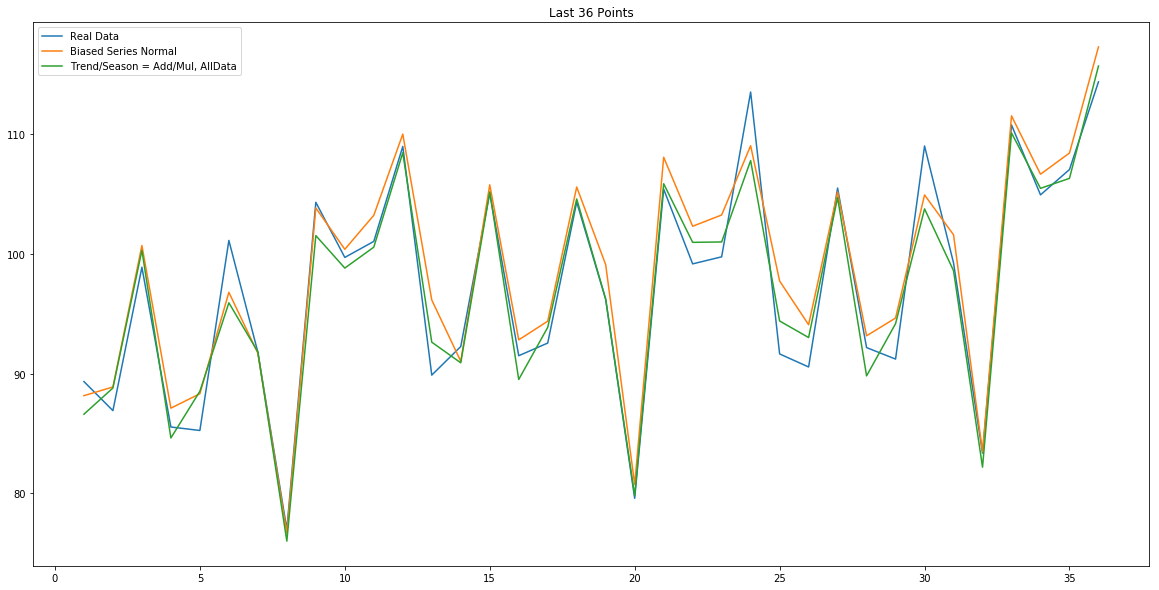

In [22]:
totPoints = len(allData.Demand.values)
import matplotlib.pyplot as plt
import numpy as np
pointsToUse = 36
x = np.arange(1,pointsToUse+1)

plt.plot(x, allData.Demand.values[-pointsToUse:], label='Real Data')
plt.plot(x, biasSeriesNormal[-pointsToUse:], label='Biased Series Normal')
# plt.plot(x, biasSeriesUnif[-pointsToUse:], label='Biased Series Uniform')
#     plt.plot(x, valForecasted[:,1][-pointsToUse:], label='Trend/Season = Add/Add, 60Points')
plt.plot(x, valForecasted[:,2][-pointsToUse:], label='Trend/Season = Add/Mul, AllData')
#     plt.plot(x, valForecasted[:,3][-pointsToUse:], label='Trend/Season = Add/Mul, 60Points')
plt.title('Last '+str(pointsToUse)+' Points')
plt.rcParams['figure.figsize'] = [20, 10]
plt.legend()
plt.show()

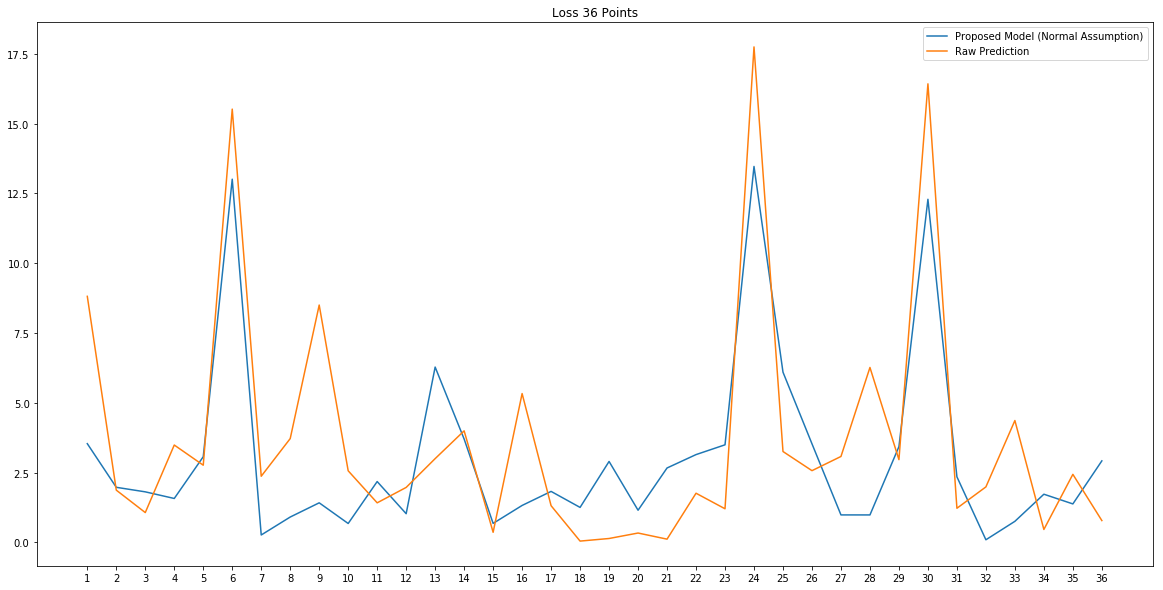

In [23]:
pointsToUse = 36

lossBiasedNormal = \
    np.maximum(biasSeriesNormal[-pointsToUse:] - valForecasted[:,4][-pointsToUse:],0) *1 \
    + np.maximum(valForecasted[:,4][-pointsToUse:] - biasSeriesNormal[-pointsToUse:],0) *3
    
lossRaw = \
    np.maximum(valForecasted[:,0][-pointsToUse:] - valForecasted[:,4][-pointsToUse:],0) *1 \
    + np.maximum(valForecasted[:,4][-pointsToUse:] - valForecasted[:,0][-pointsToUse:],0) *3

totPoints = len(allData.Demand.values)
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(1,pointsToUse+1)
plt.plot(x, lossBiasedNormal, label='Proposed Model (Normal Assumption)')  
plt.plot(x, lossRaw, label='Raw Prediction')
plt.title('Loss '+str(pointsToUse)+' Points')
plt.rcParams['figure.figsize'] = [20, 10]
plt.legend()
plt.xticks(np.arange(1,pointsToUse+1))
plt.show()

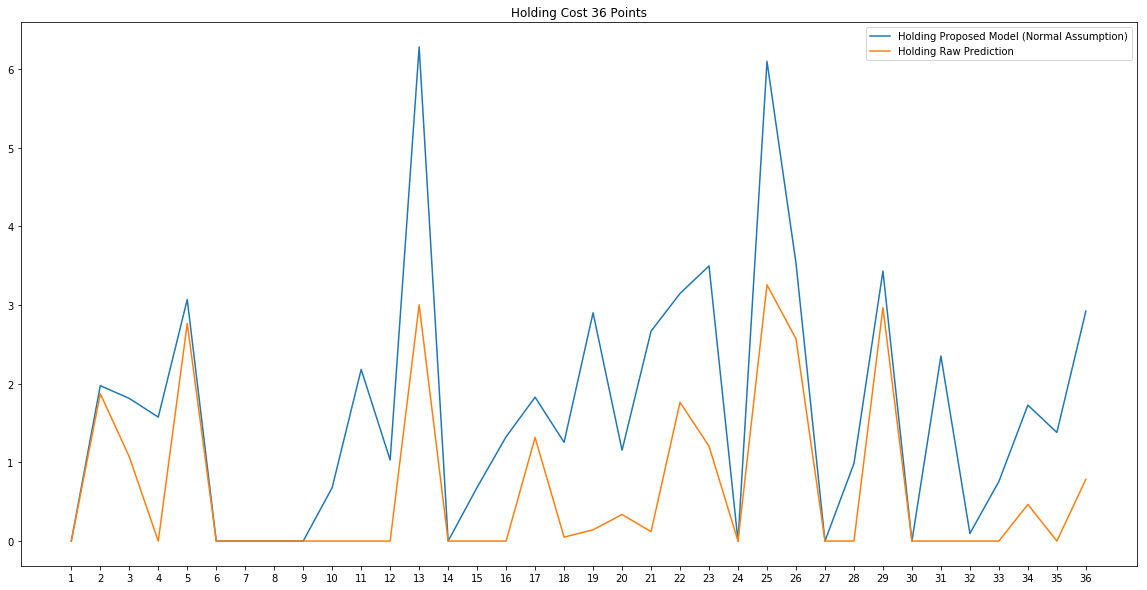

In [24]:
holdingNormal = np.maximum(biasSeriesNormal[-pointsToUse:] - valForecasted[:,4][-pointsToUse:],0)
    
shortageNormal = np.maximum(valForecasted[:,4][-pointsToUse:] - biasSeriesNormal[-pointsToUse:],0)*3

holdingRaw = np.maximum(valForecasted[:,0][-pointsToUse:] - valForecasted[:,4][-pointsToUse:],0)
    
shortageRaw = np.maximum(valForecasted[:,4][-pointsToUse:] - valForecasted[:,0][-pointsToUse:],0)*3
    


totPoints = len(allData.Demand.values)
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(1,pointsToUse+1)
plt.plot(x, holdingNormal, label='Holding Proposed Model (Normal Assumption)')  
# plt.plot(x, shortageNormal, label='Shortage Proposed Model (Normal Assumption)')
plt.plot(x, holdingRaw, label='Holding Raw Prediction')  
# plt.plot(x, shortageRaw, label='Shortage Raw Prediction')
plt.title('Holding Cost '+str(pointsToUse)+' Points')
plt.rcParams['figure.figsize'] = [20, 10]
plt.legend()
plt.xticks(np.arange(1,pointsToUse+1))
plt.show()

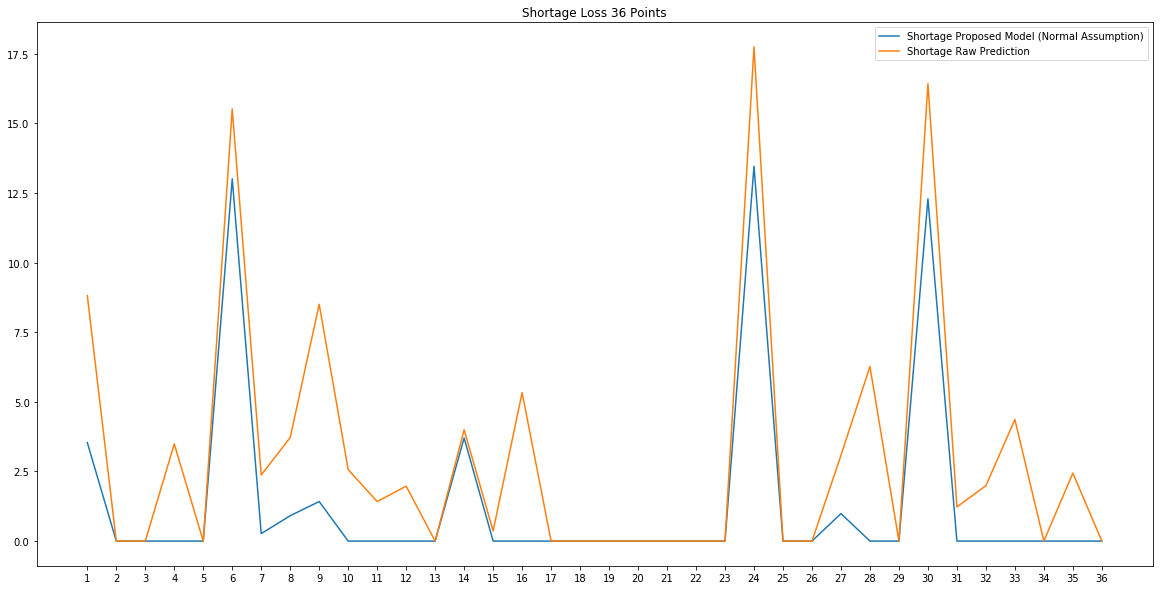

In [25]:
totPoints = len(allData.Demand.values)
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(1,pointsToUse+1)
# plt.plot(x, holdingNormal, label='Holding Proposed Model (Normal Assumption)')  
plt.plot(x, shortageNormal, label='Shortage Proposed Model (Normal Assumption)')
# plt.plot(x, holdingRaw, label='Holding Raw Prediction')  
plt.plot(x, shortageRaw, label='Shortage Raw Prediction')
plt.title('Shortage Loss '+str(pointsToUse)+' Points')
plt.rcParams['figure.figsize'] = [20, 10]
plt.legend()
plt.xticks(np.arange(1,pointsToUse+1))
plt.show()

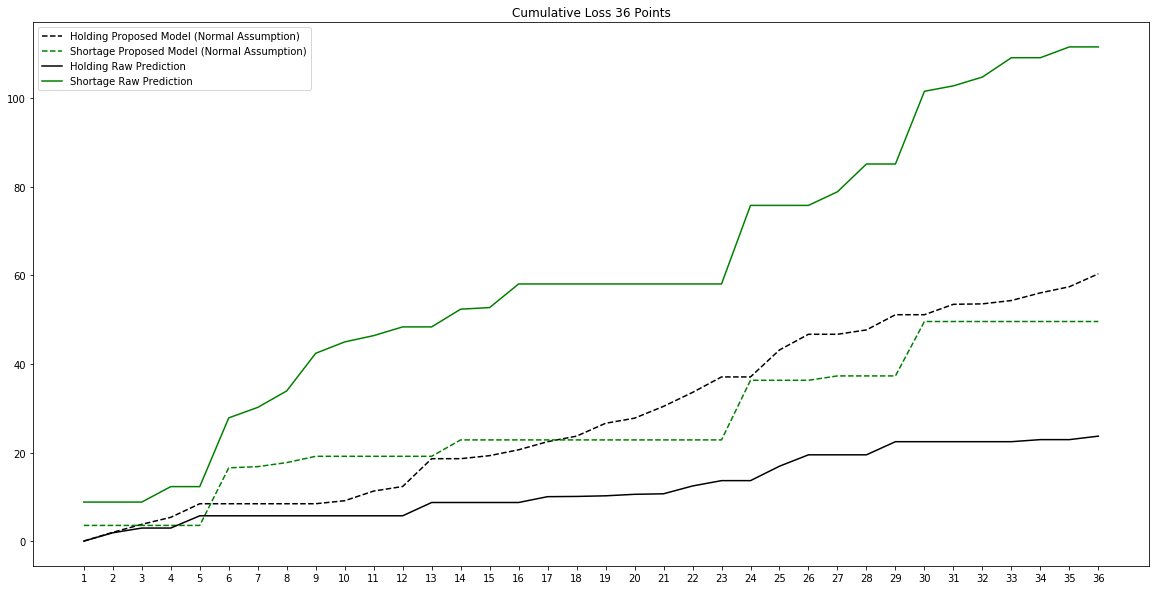

In [26]:
totPoints = len(allData.Demand.values)
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(1,pointsToUse+1)
plt.plot(x, np.cumsum(holdingNormal), label='Holding Proposed Model (Normal Assumption)', ls = '--', color= 'black')  
plt.plot(x, np.cumsum(shortageNormal), label='Shortage Proposed Model (Normal Assumption)', ls = '--', color= 'g')
plt.plot(x, np.cumsum(holdingRaw), label='Holding Raw Prediction', color= 'black')  
plt.plot(x, np.cumsum(shortageRaw), label='Shortage Raw Prediction', color= 'g')
plt.title('Cumulative Loss '+str(pointsToUse)+' Points')
plt.rcParams['figure.figsize'] = [20, 10]
plt.legend()
plt.xticks(np.arange(1,pointsToUse+1))
plt.show()

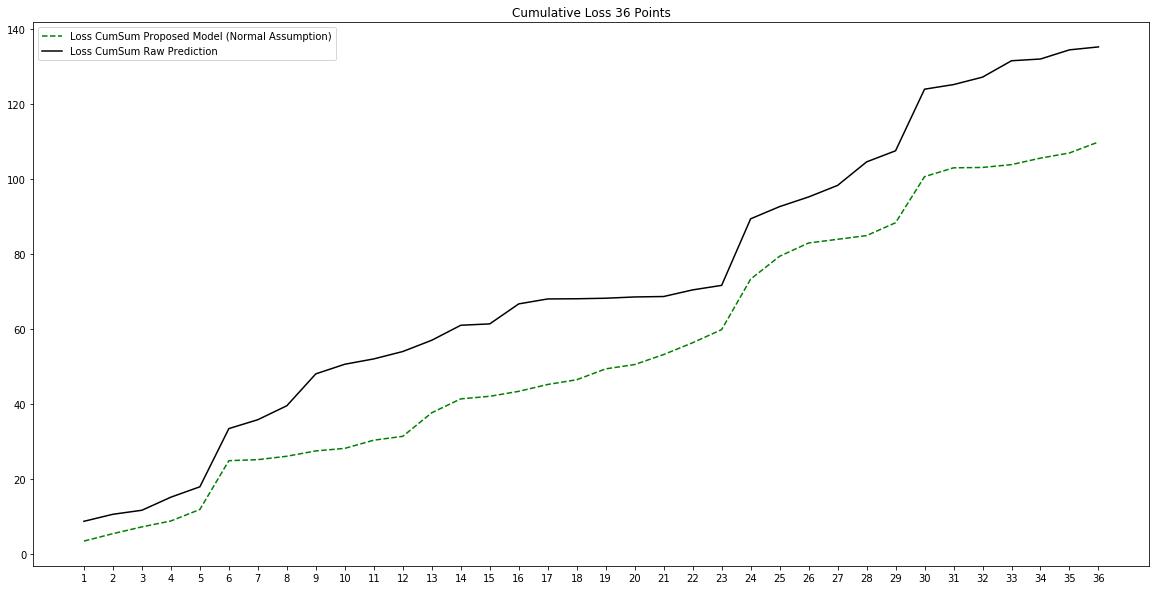

In [27]:
totPoints = len(allData.Demand.values)
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(1,pointsToUse+1)
plt.plot(x, np.cumsum(holdingNormal)+np.cumsum(shortageNormal), label='Loss CumSum Proposed Model (Normal Assumption)', ls = '--', color= 'g')  
plt.plot(x, np.cumsum(holdingRaw) + np.cumsum(shortageRaw), label='Loss CumSum Raw Prediction', color= 'black')  
plt.title('Cumulative Loss '+str(pointsToUse)+' Points')
plt.rcParams['figure.figsize'] = [20, 10]
plt.legend()
plt.xticks(np.arange(1,pointsToUse+1))
plt.show()

## Let's save the results in a nice format to then compare with LSTM and ARIMA

In [28]:
dfFinal = pd.DataFrame()

In [29]:
dfFinal['Month'] = allData['Month']
dfFinal['Year'] = allData['Year']
dfFinal['Demand'] = allData['Demand']
dfFinal['PredRaw'] = 0
dfFinal.loc[60:,'PredRaw'] = valForecasted[:,0]
dfFinal['PredPlusBias'] = 0
dfFinal.loc[84:,'PredPlusBias'] = biasSeriesNormal[-36:]

In [30]:
dfFinal['ErrorRaw'] = 0
dfFinal.loc[60:,'ErrorRaw'] = dfFinal['Demand'][60:] - dfFinal['PredRaw'][60:]
dfFinal['ErrorBiased'] = 0
dfFinal.loc[84:,'ErrorBiased'] = dfFinal['Demand'][84:] - dfFinal['PredPlusBias'][84:]

In [31]:
dfFinal['HolC_RAW'] = np.maximum(np.array(dfFinal['PredRaw']) - np.array(dfFinal['Demand']), 0)
dfFinal['HolC_Biased'] = np.maximum(np.array(dfFinal['PredPlusBias']) - np.array(dfFinal['Demand']), 0)
dfFinal['ShorC_RAW'] = np.maximum(np.array(dfFinal['Demand']) - np.array(dfFinal['PredRaw']), 0) *3
dfFinal['ShorC_Biased'] = np.maximum(np.array(dfFinal['Demand']) - np.array(dfFinal['PredPlusBias']), 0) * 3
dfFinal.loc[:84,'HolC_RAW'] = 0.0
dfFinal.loc[:84,'HolC_Biased'] = 0.0
dfFinal.loc[:84,'ShorC_RAW'] = 0.0
dfFinal.loc[:84,'ShorC_Biased'] = 0.0

In [32]:
pickle.dump(dfFinal, open('dfFinal.p',"wb"))

In [33]:
dfFinal

,Month,Year,Demand,PredRaw,PredPlusBias,ErrorRaw,ErrorBiased,HolC_RAW,HolC_Biased,ShorC_RAW,ShorC_Biased
0,1,1996,79.35,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,2,1996,75.78,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,3,1996,86.32,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,4,1996,72.60,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,5,1996,74.86,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
115,8,2005,83.36,82.696565,83.457132,0.663435,-0.097132,0.000000,0.097132,1.990306,0.0
116,9,2005,110.80,109.344519,111.557626,1.455481,-0.757626,0.000000,0.757626,4.366444,0.0
117,10,2005,104.95,105.416084,106.678595,-0.466084,-1.728595,0.466084,1.728595,0.000000,0.0
118,11,2005,107.07,106.256620,108.450988,0.813380,-1.380988,0.000000,1.380988,2.440140,0.0
